# Homework 2
### Marco Sicklinger, 03/2021


We first define some useful functions and classes.

In [1108]:
import torch as pt
from typing import List
from IPython.display import clear_output

We define, like taught in the laboratory, and `AvarageMeter()` class.

In [1109]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

We also provide a simple dataloader for better handling of data.

In [1110]:
class dataloader():
    """
    Dataloader for matrix-like inputs and vector-like outputs
    """

    def __init__(self, X, y):
        self._X = pt.tensor(X)
        self._y = pt.tensor(y)

    def __len__(self):
        return self._X.size()[0]
    
    def __getitem__(self, index):
        return self._X[index,:], self._y[index]

In order to create the required data we define a function to use when symmetric vectors are required, `mirror_vectors`, and a function to create generic random vectors, `random_vector()`.  
In addition to that, we define a function, `symmetry()`, that allows us to determin if a vector satisfy the "mirror property".  
Finally, we defined a function that allows us to create the final dataset needed for the `dataloader()`.

In [1111]:
def symmetry(x):

    if len(x)%2 != 0: return 0

    for i in range(len(x)//2):
        if x[i] != x[-(i+1)]: 
            return 0
    return 1

In [1112]:
def mirror_vectors(n: int = 6):
    
    vectors = pt.empty((2**n, n))

    x = pt.arange((2**n))
    for i in range(n):
        m = 2**(i+1)
        vectors[:, i] = x%m < 2**i

    y = pt.Tensor([symmetry(vectors[i, :]) for i in range(2**n)])
    
    return vectors, y

We also defined a function needed to compute the accuracy. Since, this quantity is neede for each vector, we defined a function to compute it for each prediction associated to every vector passed with the `dataloader()`.

In [1113]:
def local_accuracy(y_hat, y):

    prediction = round(y_hat.item())
    if  prediction == y.item():
        return 1
    else:
        return 0

Then we define the multi-layer perceptron, the training functions and the test function, following the protocol used in class.

In [1114]:
class MultiLayerPerceptron(pt.nn.Module):

    def __init__(self):
        super().__init__()

        # Create members to simulate layers
        self._h_layer = pt.nn.Linear(in_features = 6, out_features = 2, bias = True)
        self._o_layer = pt.nn.Linear(in_features = 2, out_features = 1, bias = True)

    def forward(self, X):

        out = self._h_layer(X)
        out = pt.sigmoid(out)

        out = self._o_layer(out)
        out = pt.sigmoid(out)

        return out

In [1115]:
def train_epoch(model, data, loss_ft, optimizer, loss_meter, accuracy_meter):

    for x, y in data:

        optimizer.zero_grad()

        y_hat = model(x).ravel()

        loss = loss_ft(y_hat, y)

        loss.backward()

        optimizer.step()

        loss_meter.update(val=loss.item(), n=x.shape[0])

        acc = local_accuracy(y_hat, y)
        accuracy_meter.update(val=acc, n=x.shape[0])

In [1116]:
def train_model(model, data, loss_ft, optimizer, num_epochs): 
    model.train()

    losses = []

    for epoch in range(num_epochs):

        loss_meter = AverageMeter()

        accuracy_meter = AverageMeter()

        train_epoch(model, data, loss_ft, optimizer, loss_meter, accuracy_meter)

        losses.append(loss_meter.sum)

        #print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Accuracy: {accuracy_meter.avg}")
    
    return accuracy_meter.avg, losses

In [1117]:
def test_model(model, data, loss_ft=None):

    if loss_ft is not None:
        loss_meter = AverageMeter()
        accuracy_meter = AverageMeter()

    model.eval() 

    with pt.no_grad():
        for x, y in data:
            y_hat = model(x)
            loss = loss_ft(y_hat, y) if loss_ft is not None else None
            acc = local_accuracy(y_hat, y)
            if loss_ft is not None:
                loss_meter.update(loss.item(), x.shape[0])
            accuracy_meter.update(acc, x.shape[0])

    print(f"TESTING - loss {loss_meter.sum if loss_ft is not None else '--'} - Accuracy {accuracy_meter.avg}")

Here we create the data, we define the dataloader and the loss function, and we train over the data

In [1121]:
X, y = mirror_vectors()
data = dataloader(X,y)
loss_ft = pt.nn.MSELoss(reduction="sum")
clear_output()

loss_threshold = 50

model = MultiLayerPerceptron()

optimizer = pt.optim.SGD(model.parameters(), lr=0.1)

acc, losses = train_model(model, data, loss_ft, optimizer, num_epochs)

loss_threshold = losses[-1]

print("loss {} -- accuracy {}".format(loss_threshold, acc))

loss 41.80533053353429 -- accuracy 0.875


We can inspect the weights by the following commands:

In [1122]:
for par_name, par in model.state_dict().items():
    print(par_name,par,'\n')
    print('----------------')

_h_layer.weight tensor([[ 1.2777,  0.4338, -0.1220, -0.1634,  0.1941,  1.1974],
        [-0.3665, -0.6469, -0.3032,  0.0667,  0.4168,  0.0873]]) 

----------------
_h_layer.bias tensor([ 0.1894, -0.6284]) 

----------------
_o_layer.weight tensor([[-1.0898, -0.5160]]) 

----------------
_o_layer.bias tensor([-0.9566]) 

----------------


It is possible to notice a difference in the weights with respect to those indicated in the paper. This is probably due to the fact that we use a different learning rule.

In addition, it is possible tom plot the computations of the loss function for the model found:

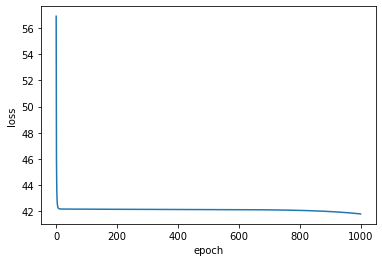

In [1123]:
import matplotlib.pyplot as plt 
axis = [i for i in range(num_epochs)]
_ = plt.plot(axis,losses)
__ = plt.xlabel('epoch') 
___ = plt.ylabel('loss')

Finally we proceed with the test on some other data, created in the same way as before.

In [1125]:
X_test, y_test = mirror_vectors()
X_test = data_creator(X1_test,X2_test)
data_test = dataloader(X_test, y_test)
clear_output()

In [1127]:
test_model(model, data_test, loss_ft=pt.nn.MSELoss(reduction="sum"))

TESTING - loss 15.714829869568348 - Accuracy 0.88


The above result was expected since we are operating once again over the same vectors.